## Import Statements and Data

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

from collections.abc import Sequence
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D,MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image
import tensorflow as tf
tf.test.gpu_device_name()


2024-10-31 15:04:19.403148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

In [3]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [244]:
data_base = pd.read_csv("GOOG.csv")
data_base = data_base.drop(columns=['Adj Close'])

data = pd.DataFrame(data_base)
data['CloseY'] = data_base['Close']

In [245]:
print("Base Data Shape : ", data.shape)
print("Base Data Column : ", data.columns)

Base Data Shape :  (3578, 7)
Base Data Column :  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseY'], dtype='object')


In [248]:
data.head()

,Date,Open,High,Low,Close,Volume,CloseY
0,2004-08-19,49.676899,51.693783,47.669952,49.845802,44994500,49.845802
1,2004-08-20,50.178635,54.187561,49.925285,53.805050,23005800,53.805050
2,2004-08-23,55.017166,56.373344,54.172661,54.346527,18393200,54.346527
3,2004-08-24,55.260582,55.439419,51.450363,52.096165,15361800,52.096165
4,2004-08-25,52.140873,53.651051,51.604362,52.657513,9257400,52.657513


In [247]:
data_base['Date'] = pd.to_datetime(data_base['Date'])
data_base["Date"].dtype


dtype('<M8[ns]')

## Data Pre processing

In [ ]:
# encode_numeric_zscore(data, 'Open')
# encode_numeric_zscore(data, 'High')
# encode_numeric_zscore(data, 'Low')
# encode_numeric_zscore(data, 'Volume')
# encode_numeric_zscore(data, 'Close')

In [ ]:
# data.head()

,Date,Open,High,Low,Close,Volume,CloseY
0,2004-08-19,-1.334844,-1.331443,-1.337457,-1.333645,4.533247,49.845802
1,2004-08-20,-1.333101,-1.322843,-1.329562,-1.319893,1.870138,53.805050
2,2004-08-23,-1.316291,-1.315305,-1.314693,-1.318012,1.311494,54.346527
3,2004-08-24,-1.315446,-1.318526,-1.324223,-1.325828,0.944353,52.096165
4,2004-08-25,-1.326284,-1.324693,-1.323684,-1.323879,0.205033,52.657513


## Pre Processing (Dense)

In [249]:
data_dense = pd.DataFrame(data)
data_dense = data_dense.drop(columns=['Date', 'CloseY'])

In [250]:
data_dense.shape

(3578, 5)

In [251]:
df_concat = pd.DataFrame()
    
# For each offset in the window of `num_rows`
for i in range(8):
  if i == 7 : 
    shifted = data_dense.shift(-i).add_suffix(f"_{i+1}")
    df_concat = pd.concat([df_concat, shifted[f'Close_{i+1}']], axis=1)
    continue

  shifted = data_dense.shift(-i).add_suffix(f"_{i+1}")
  df_concat = pd.concat([df_concat, shifted], axis=1)
    
    # Drop the rows at the end where we don't have enough data to form a full window of `num_rows`
  df_concat = df_concat.dropna().reset_index(drop=True)

df_concat.shape



(3578, 36)

In [252]:
total_nans = df_concat.isna().sum().sum()
print("Total NaN values in df_concat:", total_nans)

Total NaN values in df_concat: 217


In [253]:
df_concat = df_concat.dropna().reset_index(drop=True)

In [254]:
total_nans = df_concat.isna().sum().sum()
print("Total NaN values in df_concat:", total_nans)

Total NaN values in df_concat: 0


In [255]:
df_concat.head()

,Open_1,High_1,Low_1,Close_1,Volume_1,Open_2,High_2,Low_2,Close_2,Volume_2,...,High_6,Low_6,Close_6,Volume_6,Open_7,High_7,Low_7,Close_7,Volume_7,Close_8
0,49.676899,51.693783,47.669952,49.845802,44994500.0,50.178635,54.187561,49.925285,53.805050,23005800.0,...,53.626213,51.991844,53.606342,7148200.0,53.700729,53.959049,52.503513,52.732029,6258300.0,50.675404
1,50.178635,54.187561,49.925285,53.805050,23005800.0,55.017166,56.373344,54.172661,54.346527,18393200.0,...,53.959049,52.503513,52.732029,6258300.0,52.299839,52.404160,50.675404,50.675404,5235700.0,50.854240
2,55.017166,56.373344,54.172661,54.346527,18393200.0,55.260582,55.439419,51.450363,52.096165,15361800.0,...,52.404160,50.675404,50.675404,5235700.0,50.819469,51.519913,50.749920,50.854240,4954800.0,49.801090
3,55.260582,55.439419,51.450363,52.096165,15361800.0,52.140873,53.651051,51.604362,52.657513,9257400.0,...,51.519913,50.749920,50.854240,4954800.0,51.018177,51.152302,49.512966,49.801090,9206800.0,50.427021
4,52.140873,53.651051,51.604362,52.657513,9257400.0,52.135906,53.626213,51.991844,53.606342,7148200.0,...,51.152302,49.512966,49.801090,9206800.0,49.274517,50.854240,49.150326,50.427021,15232100.0,49.681866


In [258]:
for col in df_concat: 
  if col == 'Close_8':
    continue

  encode_numeric_zscore(df_concat, col)

In [259]:
df_concat.head()

,Open_1,High_1,Low_1,Close_1,Volume_1,Open_2,High_2,Low_2,Close_2,Volume_2,...,High_6,Low_6,Close_6,Volume_6,Open_7,High_7,Low_7,Close_7,Volume_7,Close_8
0,-1.335537,-1.332376,-1.337956,-1.334293,4.529202,-1.334126,-1.324097,-1.330467,-1.320938,1.874542,...,-1.327571,-1.325088,-1.323352,-0.048453,-1.324049,-1.326806,-1.323711,-1.326788,-0.156379,50.675404
1,-1.333787,-1.323742,-1.330032,-1.320490,1.867809,-1.317263,-1.316533,-1.315552,-1.319052,1.314682,...,-1.326422,-1.323294,-1.326394,-0.156544,-1.328921,-1.332174,-1.330118,-1.333940,-0.280582,50.854240
2,-1.316915,-1.316173,-1.315111,-1.318603,1.309525,-1.316415,-1.319765,-1.325112,-1.326894,0.946743,...,-1.331793,-1.329704,-1.333549,-0.280754,-1.334070,-1.335228,-1.329857,-1.333318,-0.314700,49.801090
3,-1.316066,-1.319407,-1.324675,-1.326448,0.942621,-1.327288,-1.325954,-1.324571,-1.324937,0.205814,...,-1.334847,-1.329443,-1.332927,-0.314873,-1.333379,-1.336497,-1.334192,-1.336980,0.201739,50.427021
4,-1.326945,-1.325599,-1.324134,-1.324491,0.203777,-1.327305,-1.326040,-1.323210,-1.321631,-0.050192,...,-1.336117,-1.333780,-1.336591,0.201593,-1.339444,-1.337526,-1.335464,-1.334803,0.933560,49.681866


In [260]:
x, y = to_xy(df_concat, 'Close_8')


In [261]:
y[:5]

array([50.675404, 50.85424 , 49.80109 , 50.42702 , 49.681866],
      dtype=float32)

In [262]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=.20, random_state = 42)

In [263]:
y_train[:5]

array([164.9273  ,  88.722946, 302.57703 , 237.9921  , 221.2013  ],
      dtype=float32)

## Train/Test Split CNN

In [277]:
# CNN input must be 4 dimensions
x_train_cnn = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], 1))

# One hot encoded output
y_train_cnn = y_train
y_test_cnn = y_test


## Train/Test Split (RNN)

In [209]:
# Filter before 2014 is train, after 2014 is test
train_data_seq = data[data['Date'] < '2014-01-01']
test_data_seq = data[(data['Date'] >= '2014-01-01') & (data['Date'] < '2018-01-01')]

In [210]:
train_data_seq = train_data_seq.drop(columns=['Date'])
test_data_seq= test_data_seq.drop(columns=['Date'])

In [211]:
train_data_seq = train_data_seq.drop(columns=['CloseY'])
test_data_seq = test_data_seq.drop(columns=['CloseY'])

In [212]:
import numpy as np

def to_sequences(seq_size, data):
    x = []
    y = []
    
    # Ensure data is a 2D array
    data = np.array(data)

    # Loop to create sequences
    for i in range(len(data) - seq_size):  
       # Create a window of seq_size (7 rows and 5 columns)
        window = data[i:(i + seq_size), :4]  # Extract all 5 columns for the 7 days
        
        # The value to predict is from the next row (8th day), which is after the window
        after_window = data[i + seq_size, -1]  # Predict the last column value (from the 8th row)

        x.append(window)  # Add the window (7x5) to x
        y.append(after_window)  # Add the target value (8th day) to y

    return np.array(x), np.array(y)


In [213]:
SEQUENCE_SIZE = 7
x_train_seq,y_train_seq = to_sequences(SEQUENCE_SIZE,train_data_seq)
x_test_seq,y_test_seq = to_sequences(SEQUENCE_SIZE,test_data_seq)

print("Shape of x_train: {}".format(x_train_seq.shape))
print("Shape of x_test: {}".format(x_test_seq.shape))
print("Shape of y_train: {}".format(y_train_seq.shape))
print("Shape of y_test: {}".format(y_test_seq.shape))

Shape of x_train: (2352, 7, 4)
Shape of x_test: (1000, 7, 4)
Shape of y_train: (2352,)
Shape of y_test: (1000,)


## Dense Model #1

In [274]:
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import concatenate
from keras.optimizers import Adam, SGD

In [275]:
# filepath = './dnn/best_weights-base.keras'
# checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.0005, momentum=0.9, nesterov=True, clipvalue=1.0)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=25,verbose=1, mode='auto')

model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# print(model.summary())
# plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=sgd_optimizer)
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test), 
          callbacks=[monitor],verbose=2,epochs=250)
  
print('Training model 1 finished...Loading the best model')
print()
# model.load_weights(filepath)

pred_base = model.predict(x_test)
score_base = np.sqrt(metrics.mean_squared_error(pred_base,y_test))
print("Score (RMSE): {}".format(score_base))

Epoch 1/250
90/90 - 3s - 33ms/step - loss: 44127.0156 - val_loss: 5970.8872
Epoch 2/250
90/90 - 1s - 12ms/step - loss: 3693.9775 - val_loss: 7051.7544
Epoch 3/250
90/90 - 1s - 9ms/step - loss: 2855.2908 - val_loss: 2417.0681
Epoch 4/250
90/90 - 1s - 9ms/step - loss: 2427.0554 - val_loss: 3119.7944
Epoch 5/250
90/90 - 1s - 9ms/step - loss: 4125.0317 - val_loss: 764.9488
Epoch 6/250
90/90 - 1s - 9ms/step - loss: 2752.9934 - val_loss: 5326.9712
Epoch 7/250
90/90 - 1s - 10ms/step - loss: 3629.6372 - val_loss: 5337.7769
Epoch 8/250
90/90 - 1s - 10ms/step - loss: 4299.5098 - val_loss: 1861.4534
Epoch 9/250
90/90 - 1s - 11ms/step - loss: 3318.8696 - val_loss: 3449.1489
Epoch 10/250
90/90 - 1s - 14ms/step - loss: 3109.7966 - val_loss: 5787.3472
Epoch 11/250
90/90 - 1s - 9ms/step - loss: 3191.9758 - val_loss: 3887.0615
Epoch 12/250
90/90 - 1s - 10ms/step - loss: 3148.6675 - val_loss: 3036.3125
Epoch 13/250
90/90 - 1s - 10ms/step - loss: 3153.6929 - val_loss: 4903.7397
Epoch 14/250
90/90 - 1s - 

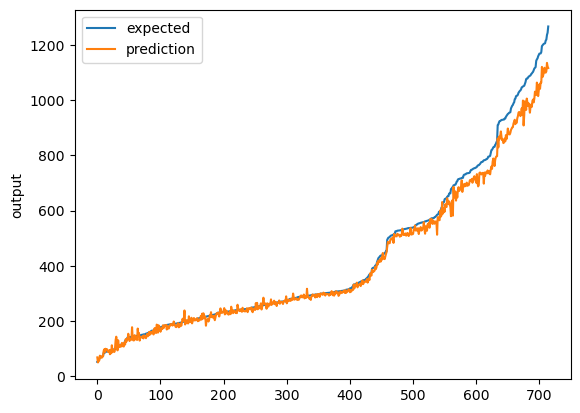

In [273]:
chart_regression(pred_base.flatten(),y_test)

## CNN Model # 1

In [ ]:
filepath = './dnn/best_weights_cnn1.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.0005, momentum=0.9, nesterov=True, clipvalue=1.0)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=25,verbose=1, mode='auto')

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), activation='relu',
                input_shape=(1, x_train_cnn.shape[2], 1)))  

cnn.add(MaxPooling2D(pool_size=(1, 2)))
cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1, 2)))


cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dense(64, activation="relu"))

cnn.add(Dense(32, activation="relu"))
cnn.add(Dense(1))

cnn.compile(loss='mean_squared_error', optimizer=adam_optimizer)
cnn.fit(x_train_cnn, y_train_cnn, validation_data=(x_test_cnn, y_test_cnn),
        callbacks=[checkpointer, monitor], verbose=2, epochs=100)

pred_cnn = cnn.predict(x_test_cnn)
score_cnn = np.sqrt(metrics.mean_squared_error(y_test, pred_cnn))
print("Score (RMSE): {}".format(score_cnn))

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
90/90 - 4s - 49ms/step - loss: 159393.1875 - val_loss: 40356.4766
Epoch 2/100
90/90 - 1s - 9ms/step - loss: 30090.7051 - val_loss: 25117.9531
Epoch 3/100
90/90 - 1s - 9ms/step - loss: 17476.6367 - val_loss: 12127.8584
Epoch 4/100
90/90 - 1s - 9ms/step - loss: 5894.1060 - val_loss: 1359.1200
Epoch 5/100
90/90 - 1s - 10ms/step - loss: 499.0141 - val_loss: 354.4261
Epoch 6/100
90/90 - 1s - 9ms/step - loss: 311.6763 - val_loss: 376.6520
Epoch 7/100
90/90 - 1s - 14ms/step - loss: 290.8637 - val_loss: 330.6385
Epoch 8/100
90/90 - 1s - 10ms/step - loss: 288.5130 - val_loss: 301.2029
Epoch 9/100
90/90 - 1s - 9ms/step - loss: 253.3039 - val_loss: 265.8256
Epoch 10/100
90/90 - 1s - 8ms/step - loss: 257.9883 - val_loss: 266.8873
Epoch 11/100
90/90 - 1s - 9ms/step - loss: 241.6860 - val_loss: 277.9291
Epoch 12/100
90/90 - 1s - 11ms/step - loss: 237.8037 - val_loss: 252.6716
Epoch 13/100
90/90 - 1s - 11ms/step - loss: 228.6139 - val_loss: 298.8279
Epoch 14/100
90/90 - 1s - 8ms/step - lo

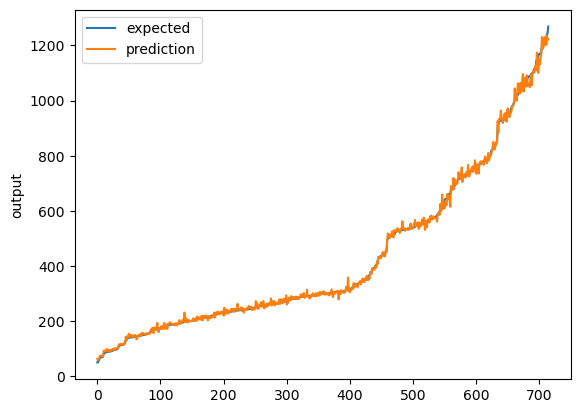

In [282]:
chart_regression(pred_cnn.flatten(),y_test_cnn)

## RNN Model # 1

In [158]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np

print('Build model...')
model = Sequential()

model.add(LSTM(64, input_shape=(SEQUENCE_SIZE, 4)))
model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, epochs=100)  

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Build model...
Train...
Epoch 1/100
74/74 - 4s - 51ms/step - loss: 186745261916160.0000 - val_loss: 5220265361408.0000
Epoch 2/100
74/74 - 1s - 7ms/step - loss: 186744037179392.0000 - val_loss: 5219908845568.0000
Epoch 3/100
74/74 - 0s - 6ms/step - loss: 186741386379264.0000 - val_loss: 5219287564288.0000
Epoch 4/100
74/74 - 0s - 6ms/step - loss: 186737527619584.0000 - val_loss: 5218452897792.0000
Epoch 5/100
74/74 - 1s - 7ms/step - loss: 186732460900352.0000 - val_loss: 5217401700352.0000
Epoch 6/100
74/74 - 0s - 6ms/step - loss: 186726286884864.0000 - val_loss: 5216136593408.0000
Epoch 7/100
74/74 - 0s - 6ms/step - loss: 186718921687040.0000 - val_loss: 5214663868416.0000
Epoch 8/100
74/74 - 0s - 6ms/step - loss: 186710465970176.0000 - val_loss: 5212981952512.0000
Epoch 9/100
74/74 - 0s - 6ms/step - loss: 186700986843136.0000 - val_loss: 5211105525760.0000
Epoch 10/100
74/74 - 0s - 6ms/step - loss: 186690501083136.0000 - val_loss: 5209059753984.0000
Epoch 11/100
74/74 - 0s - 6ms/step

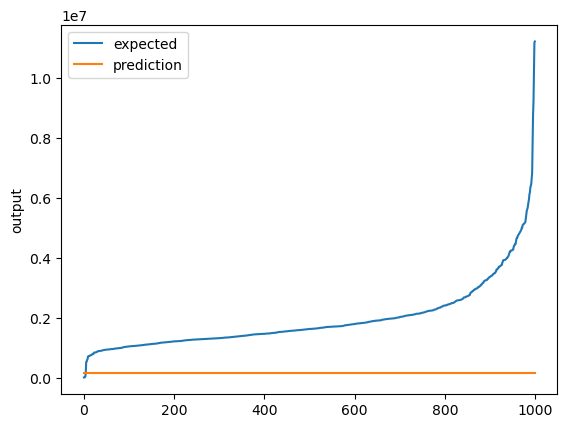

In [155]:
chart_regression(pred.flatten(),y_test)